## Decision trees for classification and regression

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree

sns.set()
import matplotlib.pyplot as plt

# sharper plots
%config InlineBackend.figure_format = 'retina'

### 1. Decision trees for regression: a toy example

Text(0, 0.5, '$y$')

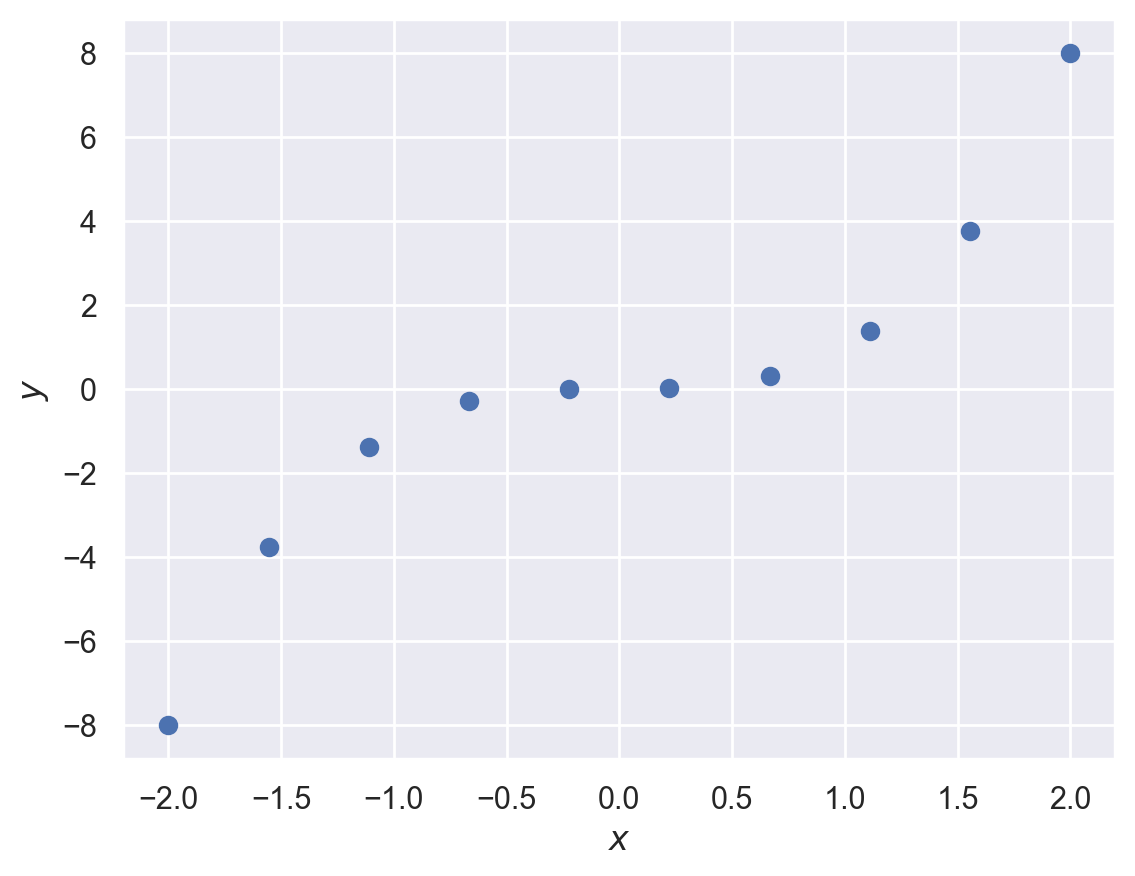

In [3]:
X = np.linspace(-2, 2, 10)
y = X ** 3

plt.scatter(X,y)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

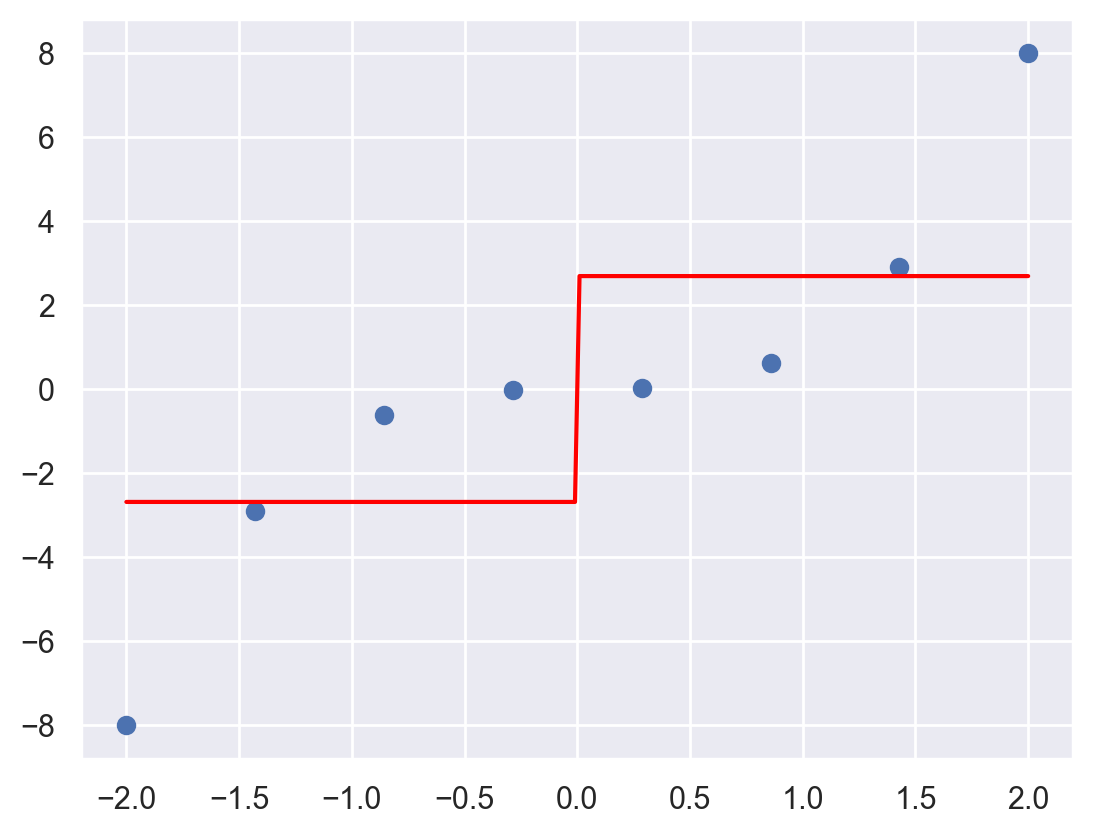

In [4]:
xx = np.linspace(-2, 2, 200)
prediction = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0]) for x in xx] ## нужно добавить разделение на 2, > 0 || < 0

X = np.linspace(-2, 2, 8)
y = X ** 3

plt.scatter(X, y)
plt.plot(xx, prediction, c="red")

In [5]:
def regression_var_criterion(X, y, t):
    X_left, X_right = X[X < t], X[X >= t]
    y_left, y_right = y[X < t], y[X >= t]

    return (
        np.var(y) 
        - X_left.shape[0] / X.shape[0] * np.var(y_left)
        - X_right.shape[0] / X.shape[0] * np.var(y_right)       
    )


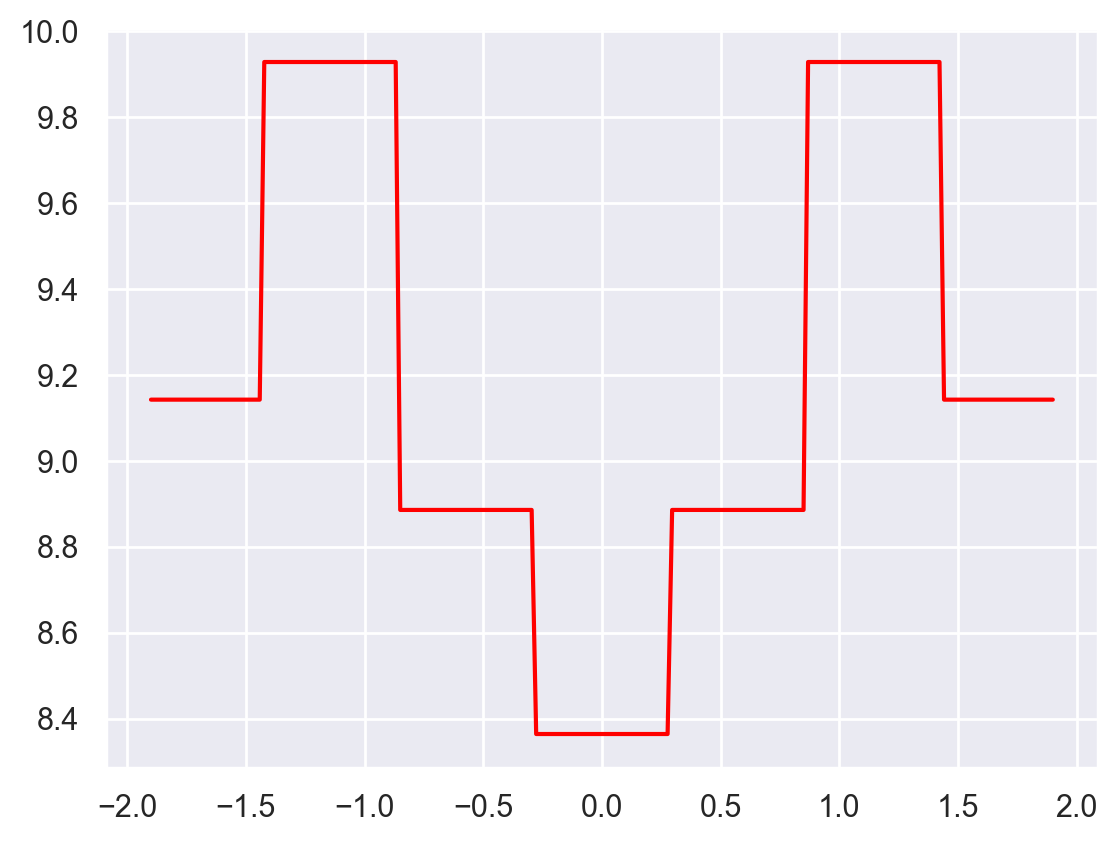

In [6]:
treshholds = np.linspace(-1.9, 1.9, 200)
crit = [regression_var_criterion(X, y, tres) for tres in treshholds]

plt.plot(treshholds, crit, c="red")

## 2. Building a decision tree for predicting heart diseases
**Problem:** Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.



In [7]:
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"
df = pd.read_csv(DATA_PATH + "mlbootcamp5_train.csv", index_col="id", sep=";")
print("Dataset size:", df.shape)
df.head()

Dataset size: (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
df["age_years"] = (df.age / 365.25).astype("int")
train_df = pd.get_dummies(df, columns=["cholesterol", "gluc"]).drop(["cardio"], axis=1)
target = df.cardio
train_df.sample(5)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,,
96771,20373,1,159,65.0,120,80,0,0,1,55,True,False,False,True,False,False
60660,22400,1,168,90.0,130,80,0,0,1,61,False,True,False,True,False,False
26935,19195,1,168,90.0,120,90,0,0,1,52,True,False,False,True,False,False
64696,15980,1,163,86.0,130,90,0,0,1,43,True,False,False,True,False,False
57638,23356,1,149,67.0,120,80,0,0,1,63,True,False,False,True,False,False


In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.3, random_state=17)

In [10]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, y_train)
accuracy_score(y_test, tree.predict(X_test))

0.7212857142857143

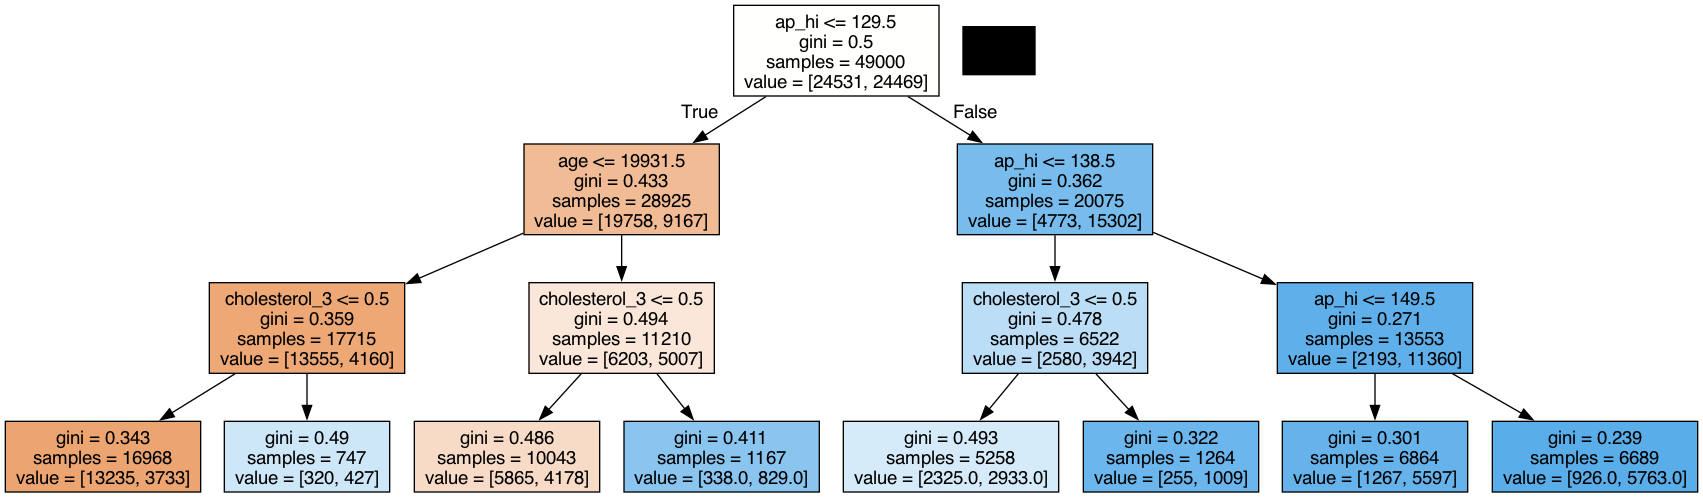

In [11]:
from io import StringIO

# pip install pydotplus
import pydotplus

# Solution code
from IPython.display import Image
# Solution code
dot_data = StringIO()
export_graphviz(tree, feature_names=train_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [12]:
# проведем кросс валидацию
tree_params = {"max_depth": range(2,11)}
tree_grid = GridSearchCV(tree, tree_params, cv=5, n_jobs=1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=1, param_grid={'max_depth': range(2, 11)}, verbose=True)

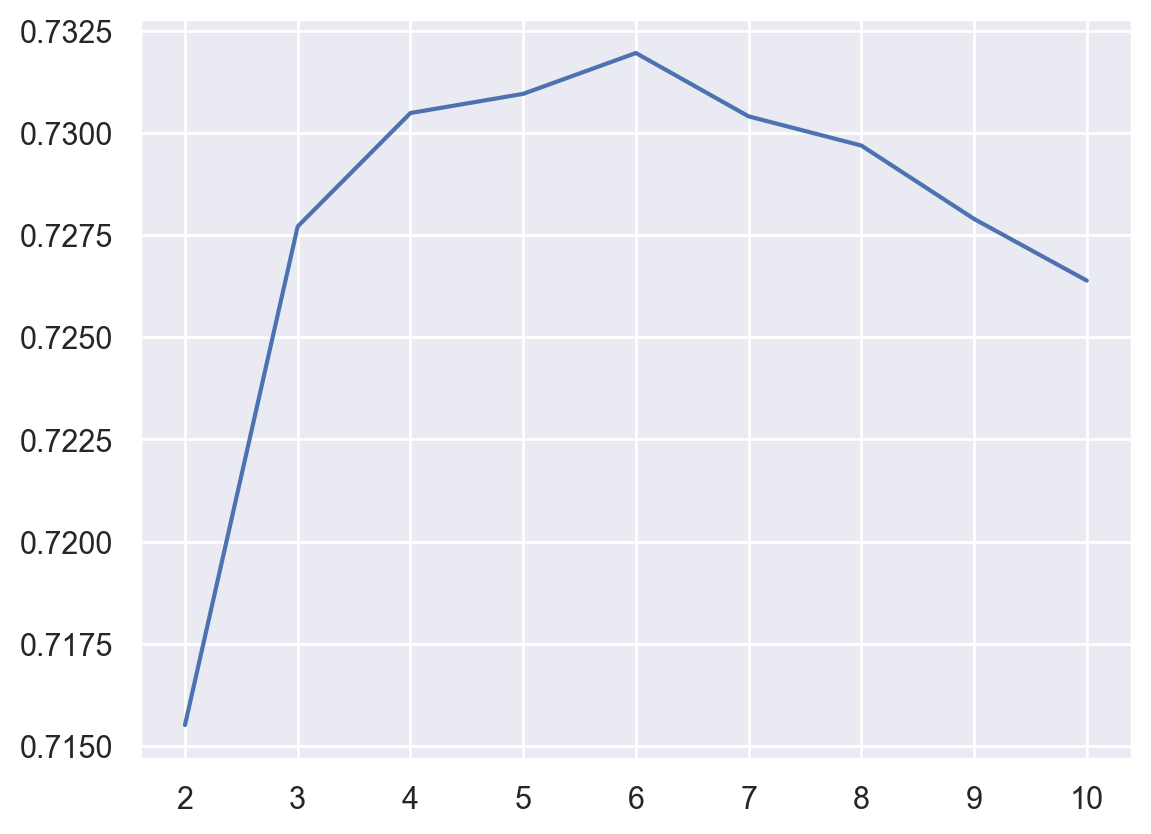

In [13]:
plt.plot(tree_params["max_depth"], tree_grid.cv_results_["mean_test_score"])

In [15]:
acc2 = accuracy_score(y_test, tree_grid.predict(X_test))
acc1 = accuracy_score(y_test, tree.predict(X_test))
acc2, acc1

(0.7258095238095238, 0.7212857142857143)

Посчитаем какой прирост получила наша модель, благодаря кросс валидации

In [ ]:
((acc2 - acc1) / acc1) * 100 # прирост качества в процетах после кросс валидации

0.6271869016967002

Создадим второй датафрейм, в котором добавим некоторые фичи

In [20]:
sub_df = pd.DataFrame(df.smoke.copy())
sub_df["male"] = df.gender - 1

sub_df["age_40_50"] = ((df.age_years >= 40) & (df.age_years < 50)).astype("int")
sub_df["age_50_55"] = ((df.age_years >= 50) & (df.age_years < 55)).astype("int")
sub_df["age_55_60"] = ((df.age_years >= 55) & (df.age_years < 60)).astype("int")
sub_df["age_60_65"] = ((df.age_years >= 60) & (df.age_years < 65)).astype("int")

sub_df["ap_hi_120_140"] = ((df.ap_hi >= 120) & (df.ap_hi < 140)).astype("int")
sub_df["ap_hi_140_160"] = ((df.ap_hi >= 140) & (df.ap_hi < 160)).astype("int")
sub_df["ap_hi_160_180"] = ((df.ap_hi >= 160) & (df.ap_hi < 180)).astype("int")

sub_df["chol=1"] = (df.cholesterol == 1).astype("int")
sub_df["chol=2"] = (df.cholesterol == 2).astype("int")
sub_df["chol=3"] = (df.cholesterol == 3).astype("int")
sub_df.head()



,smoke,male,age_40_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0


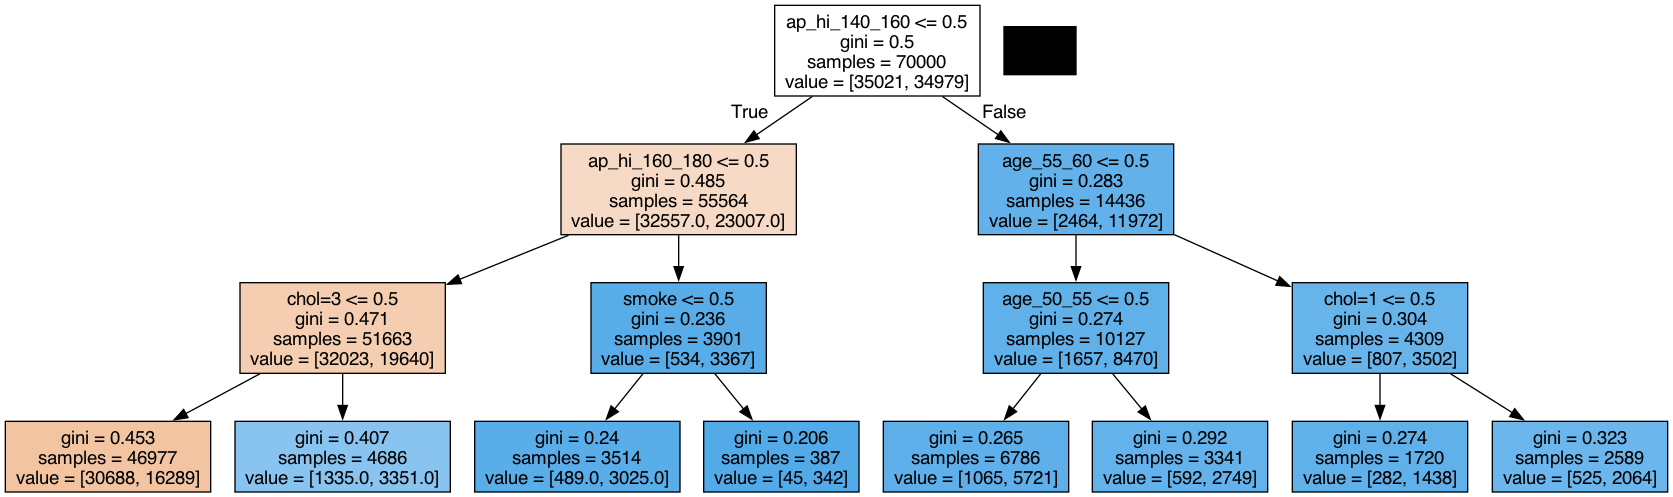

In [22]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(sub_df, target)

dot_data = StringIO()
export_graphviz(tree, feature_names=sub_df.columns, out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())
